# Feature Embeddings Extraction Notebook

In [1]:
import os
import cv2
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import multiprocessing
import tensorflow as tf
import umap.umap_ as umap
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from tensorboard.plugins import projector
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

2024-05-21 15:56:01.299439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 15:56:02.836289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dataset loading and temp+test images extraction

In [2]:
PATH = "/home/ashgatsy/DeepPCB-master/PCBData"

In [3]:
normal = []
defect = []
defectlog = []
path_2 = [os.path.join(PATH,dir) for dir in os.listdir(PATH) if '.' not in dir]
for p in tqdm(path_2,total=len(path_2)):
    path_3 = os.path.join(p,sorted(os.listdir(p))[0])
    normal +=[os.path.join(path_3,dir)for dir in os.listdir(path_3) if 'temp' in dir]
    defect +=[os.path.join(path_3,dir)for dir in os.listdir(path_3) if 'test' in dir]
    path_4 = os.path.join(p,sorted(os.listdir(p))[1])
    defectlog +=[os.path.join(path_4,dir)for dir in os.listdir(path_4)]
normal.sort()
defect.sort()
defectlog.sort()

100%|██████████| 11/11 [00:00<00:00, 479.45it/s]


In [4]:
img0 = []
img1 = []
for img_path in tqdm(normal,total=len(normal)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    img0.append(img)
for img_path in tqdm(defect,total=len(defect)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    img1.append(img)
img0 = np.array(img0)
img1 = np.array(img1)

100%|██████████| 1500/1500 [00:01<00:00, 785.93it/s]


In [5]:
def conv_to_rgb(bnw_images):
    # function that converts numpy array of bnw images to numpy array of rgb images
    num_images, height, width = bnw_images.shape
    rgb_images = np.zeros((num_images, height, width, 3), dtype=np.uint8)
    # Set all three channels to the same intensity (grayscale value)
    for i in range(num_images):
        rgb_images[i, :, :, 0] = bnw_images[i]  # Red channel
        rgb_images[i, :, :, 1] = bnw_images[i]  # Green channel
        rgb_images[i, :, :, 2] = bnw_images[i]  # Blue channel

    rgb_images = rgb_images.transpose(0, 3, 1, 2)
    return rgb_images

rgb_images0 = conv_to_rgb(img0)
rgb_images1 = conv_to_rgb(img1)

In [6]:
num_images, height, width = img0.shape
rgb_images = np.zeros((num_images, height, width, 3), dtype=np.uint8)

# Set all three channels to the same intensity (grayscale value)
for i in range(num_images):
    rgb_images[i, :, :, 0] = img0[i]  # Red channel
    rgb_images[i, :, :, 1] = img0[i]  # Green channel
    rgb_images[i, :, :, 2] = img0[i]  # Blue channel

rgb_images = rgb_images.transpose(0, 3, 1, 2)

## Import Pre-trained Model and get the dataset transformed according to the model

In [7]:
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')

def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])

model_conv_features = slice_model(model, to_layer=-1)

Using cache found in /home/ashgatsy/.cache/torch/hub/facebookresearch_WSL-Images_main


In [8]:
# define required transformations according the model imported

preprocess = transforms.Compose([
    transforms.Resize(224),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
def apply_transforms(rgb_images,transform):
    # function to apply required transformation on the dataset images
    transformed_images0 = []
    rgb_images = rgb_images.transpose(0, 2, 3, 1)
    for img_np in rgb_images:
        # Convert numpy array to PIL Image
        # print(img_np.shape)
        img_pil = Image.fromarray(img_np)

        # Apply the transformation
        img_transformed = transform(img_pil)

        # Convert the transformed image back to numpy array
        img_transformed_np = np.array(img_transformed)

        # Append to the list
        transformed_images0.append(img_transformed_np)
    return transformed_images0

transformed_images0 = apply_transforms(rgb_images0,preprocess)
transformed_images1 = apply_transforms(rgb_images1,preprocess)

In [13]:
class MyDataset(Dataset):
    def __init__(self, data, targets=None, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        if self.targets is not None:
            return sample, self.targets[idx]
        else:
            return sample

In [14]:
my_dataset0 = MyDataset(data=transformed_images0)
my_dataset1 = MyDataset(data=transformed_images1)

In [15]:
cpu_count = multiprocessing.cpu_count()
print('cpus', cpu_count)
batch_size = 16
my_dataloader0 = DataLoader(dataset=my_dataset0, batch_size=batch_size, shuffle=True, num_workers=cpu_count)
my_dataloader1 = DataLoader(dataset=my_dataset1, batch_size=batch_size, shuffle=True, num_workers=cpu_count)

cpus 4


In [16]:
def get_features(dataloader,model_conv_features):
    features_list=[]
    # this function returns the populated features list
    model_conv_features
    for batch in tqdm(dataloader):
        # print(batch.shape)
        image_batch = batch
        # image_batch = torch.stack(image_batch) 

        with torch.no_grad():
            features_batch = model_conv_features(image_batch).flatten(start_dim=1)
        features_list.append(features_batch)

    return features_list

In [17]:
features_list0 = get_features(my_dataloader0,model_conv_features)
features_list1 = get_features(my_dataloader1,model_conv_features)

 24%|██▍       | 23/94 [05:13<16:51, 14.24s/it]

In [15]:
features_list0[0][1]

tensor([0.2217, 1.7404, 0.0308,  ..., 0.2266, 0.9842, 1.0170])

## Upload the embeddings on qdrant

In [16]:
# from qdrant_client import QdrantClient
# from qdrant_client.models import Distance, VectorParams
# qdrant = QdrantClient(url='http://localhost:6333')

In [17]:
def concatenate_embeddings(features_list):
  # Reshape each tensor to remove the batch dimension
  embeddings = [tf.reshape(tensor, [-1, 2048]) for tensor in features_list]

  # Concatenate the reshaped tensors
  concatenated_embeddings = tf.concat(embeddings, axis=0)

  return concatenated_embeddings.numpy().tolist()

individual_embeddings0 = concatenate_embeddings(features_list0)
individual_embeddings1 = concatenate_embeddings(features_list1)

In [19]:
# def qdarnt_upload(collection_name,csize,vectors):
#     qdrant.recreate_collection(
#         collection_name=collection_name,
#         vectors_config=VectorParams(size=2048,distance=Distance.COSINE),
#     )
#     for i, embedding in enumerate(vectors):
#         qdrant.upsert(collection_name=collection_name, points=[{
#             'id': i,  # Unique ID for each data point
#             'vector': embedding,  # Convert numpy array to list
#             'payload': {'text': f'Embedding {i}'}  # Optional payload (metadata)
#         }])
#     print("Embeddings inserted successfully!")

# qdarnt_upload("check1",1501,individual_embeddings0)
# qdarnt_upload("check2",1500,individual_embeddings1)

## k-Means based clustering of all the embeddings

In [20]:
def cluster_embeddings(embeddings, num_clusters):
    # Flatten the list of tensors into a single 2D array
    flattened_embeddings = np.array(embeddings)

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)  # Set random_state for reproducibility
    kmeans.fit(flattened_embeddings)

    # Get cluster labels for each data point
    cluster_labels = kmeans.labels_

    return cluster_labels

In [31]:
len(individual_embeddings0)

1501

In [22]:
cluster_labels0 = cluster_embeddings(individual_embeddings0,6)

In [32]:
len(cluster_labels0)

1501

## Make a UMAP using the embeddings

In [23]:
def reduce_dim(embeddings,num_dim,seed):
    reducer = umap.UMAP(n_components=num_dim,random_state=seed)
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

umap_embeddings0 = reduce_dim(individual_embeddings0,3,42)

/home/ashgatsy/miniconda3/envs/env1/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [1]:
log_dir='/home/ashgatsy/test/logs/pcb-example1/'

def tensorboard_umap(umap_embeddings,cluster_labels):
    embedding_var = tf.Variable(umap_embeddings,name='embedding')
    checkpoint = tf.train.Checkpoint(embedding=embedding_var)
    checkpoint.save(os.path.join(log_dir,'ts_embedding.ckpt'))
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = 'embedding/.ATTRIBUTES/VARIABLE_VALUE'  # Assuming saved tensor

    # Create metadata.tsv (optional): Each line: index<tab>cluster_label
    with open('/home/ashgatsy/test/logs/pcb-example1/metadata.tsv', 'w') as f:
        print("here")
        print(len(cluster_labels))
        for i, label in enumerate(cluster_labels):
            f.write(f"{i}\t{label}\n")

    embedding.metadata_path = 'metadata.tsv'

    projector.visualize_embeddings(log_dir, config)

tensorboard_umap(umap_embeddings0,cluster_labels0)

NameError: name 'umap_embeddings0' is not defined

Text(0.5, 1.0, 'UMAP projection with 6 clusters')

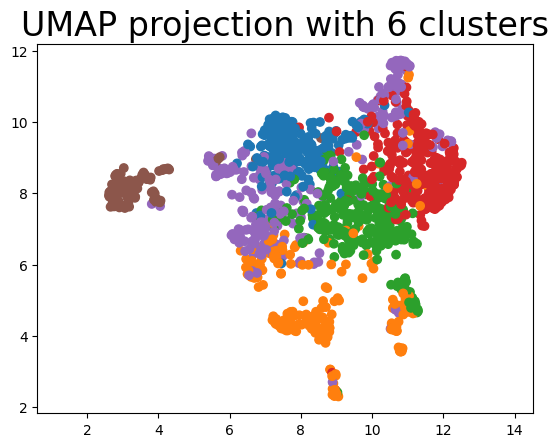

In [43]:
plt.scatter(
    umap_embeddings0[:, 0],
    umap_embeddings0[:, 1],
    c=[sns.color_palette()[label] for label in cluster_labels0])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection with 6 clusters', fontsize=24)

In [21]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

In [22]:
embedding_var = tf.Variable(individual_embeddings0, name='embedding')
embedding_var1 = tf.Variable(individual_embeddings1, name='embedding1')

In [25]:
log_dir='/home/ashgatsy/test/logs/pcb-example/'
checkpoint0 = tf.train.Checkpoint(embedding=embedding_var)
checkpoint1 = tf.train.Checkpoint(embedding=embedding_var1)
checkpoint0.save(os.path.join(log_dir, 'embedding.ckpt'))
checkpoint1.save(os.path.join(log_dir, 'embedding.ckpt1'))

'/home/ashgatsy/test/logs/pcb-example/embedding.ckpt1-1'

In [26]:
# Set up projector config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'

In [27]:
projector.visualize_embeddings(log_dir, config)

In [34]:
!tensorboard --logdir /home/ashgatsy/test/logs/pcb-example1/

2024-05-21 15:35:29.930320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 15:35:31.877982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


: 

In [ ]:
# (train_data, test_data), info = tfds.load(
#     "imdb_reviews/subwords8k",
#     split=(tfds.Split.TRAIN, tfds.Split.TEST),
#     with_info=True,
#     as_supervised=True,
# )
# encoder = info.features["text"].encoder

# # Shuffle and pad the data.
# train_batches = train_data.shuffle(1000).padded_batch(
#     10, padded_shapes=((None,), ())
# )
# test_batches = test_data.shuffle(1000).padded_batch(
#     10, padded_shapes=((None,), ())
# )
# train_batch, train_labels = next(iter(train_batches))


In [ ]:
# # Create an embedding layer.
# embedding_dim = 16
# embedding = tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim)
# # Configure the embedding layer as part of a keras model.
# model = tf.keras.Sequential(
#     [
#         embedding, # The embedding layer should be the first layer in a model.
#         tf.keras.layers.GlobalAveragePooling1D(),
#         tf.keras.layers.Dense(16, activation="relu"),
#         tf.keras.layers.Dense(1),
#     ]
# )

# # Compile model.
# model.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )

# # Train model for one epoch.
# history = model.fit(
#     train_batches, epochs=1, validation_data=test_batches, validation_steps=20
# )


In [ ]:
# # Set up a logs directory, so Tensorboard knows where to look for files.
# log_dir='/home/ashgatsy/test/logs/imdb-example/'

# # Save Labels separately on a line-by-line manner.
# with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
#   for subwords in encoder.subwords:
#     f.write("{}\n".format(subwords))
#   # Fill in the rest of the labels with "unknown".
#   for unknown in range(1, encoder.vocab_size - len(encoder.subwords)):
#     f.write("unknown #{}\n".format(unknown))


# # Save the weights we want to analyze as a variable. Note that the first
# # value represents any unknown word, which is not in the metadata, here
# # we will remove this value.
# weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# # Create a checkpoint from embedding, the filename and key are the
# # name of the tensor.
# checkpoint = tf.train.Checkpoint(embedding=weights)
# checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# # Set up config.
# config = projector.ProjectorConfig()
# embedding = config.embeddings.add()
# # The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
# embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
# embedding.metadata_path = 'metadata.tsv'
# projector.visualize_embeddings(log_dir, config)


In [ ]:
# # Now run tensorboard against on log data we just saved.
# !tensorboard --logdir /home/ashgatsy/test/logs/imdb-example/
